In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import pandas as pd
import numpy as np

path = "core_ETF.xlsx"
sheet = 0

meta = pd.read_excel(path, sheet_name=sheet, header=None, nrows=3)
tickers = meta.iloc[0].tolist()

def clean(x):
    if pd.isna(x):
        return ""
    return str(x).strip()

tickers = [clean(x) for x in tickers]

df = pd.read_excel(path, sheet_name=sheet, header=None, skiprows=3)

# 1) calendrier référence = 1ère colonne date
ref_raw = df.iloc[:, 0]
ref_num = pd.to_numeric(ref_raw, errors="coerce")
mask_excel = ref_num.between(20000, 60000)

ref_dates = ref_raw.copy()
ref_dates.loc[mask_excel] = pd.to_datetime(ref_num[mask_excel], unit="D", origin="1899-12-30")
ref_dates.loc[~mask_excel] = pd.to_datetime(ref_raw[~mask_excel], errors="coerce")

# garder seulement les lignes où la date est valide
valid = ref_dates.notna()
df = df.loc[valid].reset_index(drop=True)
ref_dates = pd.to_datetime(ref_dates.loc[valid]).reset_index(drop=True)

# 2) wide = index = ref_dates, colonnes = tickers, valeurs = colonnes "Price" uniquement
wide = pd.DataFrame(index=ref_dates)

for j in range(0, df.shape[1], 2):
    price_col = j + 1
    if price_col >= df.shape[1]:
        break

    # ticker associé à la colonne prix
    tkr = tickers[price_col] if price_col < len(tickers) and tickers[price_col] not in ("", "Date") else f"UNKNOWN_{j//2}"

    px = pd.to_numeric(df.iloc[:, price_col], errors="coerce").values
    wide[tkr] = px

wide = wide.sort_index()

# 3) Forcer les dates : combler trous intra-séries (si un ETF manque un jour)
wide = wide.ffill()

print(wide.head())
print("index min/max:", wide.index.min(), wide.index.max())
print("colonnes:", wide.shape[1])

            SWDA LN Equity  IWDA LN Equity  IWRD LN Equity  EUNL GR Equity  \
0                                                                            
2010-01-04       1632.5699           26.31          1591.0           18.17   
2010-01-05       1644.5100           26.30          1600.0           18.23   
2010-01-06       1646.7500           26.39          1604.0           18.26   
2010-01-07       1652.4399           26.30          1610.0           18.30   
2010-01-08       1652.6200           26.41          1610.0           18.39   

            CSUS LN Equity  IMEU LN Equity  CSJP LN Equity  SPXJ LN Equity  \
0                                                                            
2010-01-04           94.56       1477.3299          5823.0       2467.5300   
2010-01-05           94.50       1482.5300          5782.0       2487.8799   
2010-01-06           94.94       1483.4399          5770.0       2496.0701   
2010-01-07           96.16       1483.5401          5842.0     

In [16]:
# --- Buckets (ligne 1)
buckets = meta.iloc[1].tolist()
buckets = [clean(x) for x in buckets]

# mapping ticker -> bucket (en utilisant les mêmes price_col que pour wide)
ticker_to_bucket = {}
for j in range(0, df.shape[1], 2):
    price_col = j + 1
    if price_col >= df.shape[1]:
        break
    tkr = tickers[price_col] if price_col < len(tickers) and tickers[price_col] not in ("", "Date") else f"UNKNOWN_{j//2}"
    bkt = buckets[price_col] if price_col < len(buckets) else ""
    ticker_to_bucket[tkr] = bkt

In [17]:
themes = {
    "Equity": {"Equity DM (Core)", "Equity DM (Regional)"},
    "Rates": {"Rates EMU Govies (Core)", "Rates EMU Govies (Bucket)", "Rates EMU Govies (Linkers)"},
    "Credit": {"Credit EMU IG (Core)", "Credit EMU IG (Bucket)", "Credit EMU IG (Large Cap)",
               "Credit EMU IG (Covered)", "EMU Aggregate (IG)"},
}

In [18]:
rets = np.log(wide).diff()

def candidates_for(theme_name):
    return [t for t in wide.columns if ticker_to_bucket.get(t, "") in themes[theme_name]]

def pick_best(theme_name, min_obs=750):
    cands = candidates_for(theme_name)
    # garder ceux avec assez d'historique
    cands = [t for t in cands if rets[t].dropna().shape[0] >= min_obs]
    if len(cands) == 0:
        raise ValueError(f"Aucun candidat pour {theme_name} avec min_obs={min_obs}")

    R = rets[cands].dropna(how="all")
    corr = R.corr()
    mean_corr = corr.mean(axis=1)          # représentativité
    nobs = R.notna().sum()                 # longueur d'historique
    vol = R.std()                          # pour éviter les trucs trop extrêmes

    score = mean_corr + 0.0001*nobs - 0.1*vol
    best = score.sort_values(ascending=False).index[0]
    return best, score.sort_values(ascending=False)

best_eq, rank_eq = pick_best("Equity")
best_rt, rank_rt = pick_best("Rates")
best_cr, rank_cr = pick_best("Credit")

print("Best Equity:", best_eq, "| bucket:", ticker_to_bucket[best_eq])
print("Best Rates :", best_rt, "| bucket:", ticker_to_bucket[best_rt])
print("Best Credit:", best_cr, "| bucket:", ticker_to_bucket[best_cr])

Best Equity: SWDA LN Equity | bucket: Equity DM (Core)
Best Rates : CBE3 LN Equity | bucket: Rates EMU Govies (Bucket)
Best Credit: IEAC LN Equity | bucket: Credit EMU IG (Core)


In [19]:
# ── Construction du portefeuille Core (3 ETFs) ──
core3 = [best_eq, best_rt, best_cr]
core4 = core3   # on garde le même nom de variable pour compatibilité

# Prix sur toute la période disponible (pas de restriction)
prices = wide[core4].dropna()
rets4 = np.log(prices).diff().dropna()

mu4 = rets4.mean() * 252
cov4 = rets4.cov() * 252

print(f"Portefeuille Core : {len(core4)} ETFs")
print(f"Période : {prices.index.min().date()} → {prices.index.max().date()}")
print(f"Observations : {len(rets4)}")
print(f"\nRendements annualisés :")
for t in core4:
    print(f"  {t:25s} : ret={mu4[t]*100:.2f}%  vol={np.sqrt(cov4.loc[t,t])*100:.2f}%")

Portefeuille Core : 3 ETFs
Période : 2010-01-04 → 2025-12-31
Observations : 4040

Rendements annualisés :
  SWDA LN Equity            : ret=11.14%  vol=14.74%
  CBE3 LN Equity            : ret=0.80%  vol=1.50%
  IEAC LN Equity            : ret=0.42%  vol=4.22%


# 📈 Frontière Efficiente & Allocation — 3 ETFs Core (statique, full-sample)

On construit la frontière efficiente sur les 3 ETFs Core (SWDA, CBE3, IEAC) estimés sur **toute la période disponible** (pas de rolling ici).

Chaque méthode d'allocation est évaluée selon **3 indicateurs de concentration** :
1. **HHI** (Herfindahl) : $\sum w_i^2$ — concentration des poids. $HHI = 1/N \approx 0.333$ est le minimum.
2. **Diversification Ratio** : $DR = w^T\sigma / \sigma_p$ — exploitation des corrélations. $DR > 1$ = diversification effective.
3. **Max Risk Contribution** : $\max_i RC_i / \sum RC_i$ — part du plus gros contributeur au risque total.

In [20]:
# ═══════════════════════════════════════════════════════════
#  FRONTIÈRE EFFICIENTE — Monte Carlo + Optimization  (4 ETFs)
# ═══════════════════════════════════════════════════════════
from scipy.optimize import minimize

Sigma4 = cov4.values
mu4_arr = mu4.values
n4 = len(core4)
rf = 0.0

# ── 1) Monte Carlo : 15 000 portefeuilles aléatoires ──
np.random.seed(42)
n_sim = 15_000
weights_mc = np.random.dirichlet(np.ones(n4), n_sim)  # long-only, sum = 1

rets_mc = weights_mc @ mu4_arr
vols_mc = np.array([np.sqrt(w @ Sigma4 @ w) for w in weights_mc])
sharpe_mc = rets_mc / vols_mc

# HHI, DivRatio, MaxRC pour chaque portefeuille simulé
hhi_mc    = np.sum(weights_mc**2, axis=1)
vols_ind  = np.sqrt(np.diag(Sigma4))
dr_mc     = np.array([(w @ vols_ind) / np.sqrt(w @ Sigma4 @ w) for w in weights_mc])
def max_rc_pct(w, cov):
    vol_p = np.sqrt(w @ cov @ w)
    if vol_p < 1e-12: return 1/len(w)
    mrc = cov @ w / vol_p
    rc = w * mrc
    rc_rel = rc / rc.sum() if rc.sum() > 0 else np.ones_like(w)/len(w)
    return float(np.max(rc_rel))
maxrc_mc = np.array([max_rc_pct(w, Sigma4) for w in weights_mc])

# ── 2) Frontière efficiente exacte (optimisation target-return) ──
ret_range = np.linspace(rets_mc.min(), rets_mc.max(), 80)
frontier_vol = []
frontier_ret = []

for target in ret_range:
    def obj(w): return np.sqrt(w @ Sigma4 @ w)
    cons = [
        {"type": "eq", "fun": lambda w: w.sum() - 1},
        {"type": "eq", "fun": lambda w, t=target: w @ mu4_arr - t},
    ]
    res = minimize(obj, np.ones(n4)/n4, method="SLSQP",
                   bounds=[(0,1)]*n4, constraints=cons)
    if res.success:
        frontier_vol.append(res.fun)
        frontier_ret.append(target)

frontier_vol = np.array(frontier_vol)
frontier_ret = np.array(frontier_ret)

# ── Tangent line (CML) ──
best_idx = np.argmax(frontier_ret / frontier_vol)
cml_ret = np.linspace(0, frontier_ret.max() * 1.15, 50)

print(f"✓ {n_sim} portefeuilles simulés | {len(frontier_vol)} points de frontière")
print(f"  Ret range : [{rets_mc.min()*100:.2f}% , {rets_mc.max()*100:.2f}%]")
print(f"  Vol range : [{vols_mc.min()*100:.2f}% , {vols_mc.max()*100:.2f}%]")

✓ 15000 portefeuilles simulés | 80 points de frontière
  Ret range : [0.45% , 11.12%]
  Vol range : [1.41% , 14.71%]


In [21]:
from scipy.optimize import minimize

# ═══════════════════════════════════════════════════════════
#  FONCTIONS UTILITAIRES
# ═══════════════════════════════════════════════════════════
def compute_metrics(w, mu_vec, cov_mat):
    """Calcule ret, vol, Sharpe + 3 métriques de concentration."""
    Sigma = cov_mat.values if hasattr(cov_mat, 'values') else cov_mat
    mu_arr = mu_vec.values if hasattr(mu_vec, 'values') else mu_vec
    vols = np.sqrt(np.diag(Sigma))
    
    ret_p = float(w @ mu_arr)
    vol_p = float(np.sqrt(w @ Sigma @ w))
    sharpe = ret_p / vol_p if vol_p > 0 else 0
    
    # 1) HHI
    hhi = float(np.sum(w**2))
    
    # 2) Diversification Ratio
    dr = float((w @ vols) / vol_p) if vol_p > 0 else 1.0
    
    # 3) Max Risk Contribution (en % du risque total)
    mrc = (Sigma @ w) / vol_p if vol_p > 0 else np.zeros_like(w)
    rc = w * mrc  # risk contribution absolue
    rc_pct = rc / vol_p if vol_p > 0 else np.zeros_like(w)  # en % de la variance
    # Normaliser : contribution relative au risque total
    rc_rel = rc / rc.sum() if rc.sum() > 0 else np.ones_like(w) / len(w)
    max_rc = float(np.max(rc_rel))
    
    return {
        "Return%": ret_p * 100, "Vol%": vol_p * 100, "Sharpe": sharpe,
        "HHI": hhi, "DivRatio": dr, "MaxRC%": max_rc * 100,
    }

# ═══════════════════════════════════════════════════════════
#  MÉTHODES D'ALLOCATION (3 ETFs)
# ═══════════════════════════════════════════════════════════
n4 = len(core4)
Sigma4 = cov4.values
mu4_arr = mu4.values
vols4 = np.sqrt(np.diag(Sigma4))

# --- Min-Variance ---
def neg_vol(w): return np.sqrt(w @ Sigma4 @ w)
res = minimize(neg_vol, np.ones(n4)/n4, method="SLSQP",
               bounds=[(0,1)]*n4, constraints={"type":"eq","fun":lambda w: w.sum()-1})
w_minv4 = res.x

# --- Max-Sharpe ---
def neg_sharpe(w):
    v = np.sqrt(w @ Sigma4 @ w)
    return -(w @ mu4_arr) / v if v > 1e-10 else 1e10
res = minimize(neg_sharpe, np.ones(n4)/n4, method="SLSQP",
               bounds=[(0,1)]*n4, constraints={"type":"eq","fun":lambda w: w.sum()-1})
w_maxs4 = res.x

# --- Equal-Weight ---
w_ew4 = np.ones(n4) / n4

# --- Risk Parity ---
def risk_parity_obj(w):
    port_vol = np.sqrt(w @ Sigma4 @ w)
    mrc = Sigma4 @ w / port_vol
    rc = w * mrc
    target = port_vol / n4
    return np.sum((rc - target)**2)
res = minimize(risk_parity_obj, np.ones(n4)/n4, method="SLSQP",
               bounds=[(0.01,1)]*n4, constraints={"type":"eq","fun":lambda w: w.sum()-1})
w_rp4 = res.x

# --- Max Diversification ---
def neg_div_ratio(w):
    return -(w @ vols4) / np.sqrt(w @ Sigma4 @ w)
res = minimize(neg_div_ratio, np.ones(n4)/n4, method="SLSQP",
               bounds=[(0.01,1)]*n4, constraints={"type":"eq","fun":lambda w: w.sum()-1})
w_md4 = res.x

# --- Sharpe contraint (plafond 50%) ---
res = minimize(neg_sharpe, np.ones(n4)/n4, method="SLSQP",
               bounds=[(0.05, 0.50)]*n4, constraints={"type":"eq","fun":lambda w: w.sum()-1})
w_cstr4 = res.x

# --- Inverse Volatility ---
w_iv4 = (1/vols4) / (1/vols4).sum()

# ═══════════════════════════════════════════════════════════
#  TABLEAU COMPARATIF
# ═══════════════════════════════════════════════════════════
all4 = {
    "Min-Variance": w_minv4,
    "Max-Sharpe": w_maxs4,
    "Equal-Weight": w_ew4,
    "Risk Parity": w_rp4,
    "Max Diversif.": w_md4,
    "Sharpe plaf.50%": w_cstr4,
    "Inv. Volatility": w_iv4,
}

rows = []
for name, w in all4.items():
    m = compute_metrics(w, mu4, cov4)
    m["Méthode"] = name
    for i, t in enumerate(core4):
        m[t.split()[0] if " " in t else t[:8]] = w[i]
    rows.append(m)

df4 = pd.DataFrame(rows).set_index("Méthode")

# Affichage propre
print("=" * 90)
print("COMPARAISON — 3 ETFs Core")
print(f"Période : {prices.index.min().date()} → {prices.index.max().date()} ({len(rets4)} obs)")
print("=" * 90)
cols_w = [c for c in df4.columns if c not in ["Return%","Vol%","Sharpe","HHI","DivRatio","MaxRC%"]]
cols_m = ["Return%","Vol%","Sharpe","HHI","DivRatio","MaxRC%"]

print("\n--- Poids ---")
fmt_w = df4[cols_w].copy()
for c in cols_w:
    fmt_w[c] = fmt_w[c].apply(lambda x: f"{x*100:.1f}%")
print(fmt_w.to_string())

print("\n--- Métriques ---")
print(df4[cols_m].round(3).to_string())


COMPARAISON — 3 ETFs Core
Période : 2010-01-04 → 2025-12-31 (4040 obs)

--- Poids ---
                  SWDA   CBE3   IEAC
Méthode                             
Min-Variance      0.5%  88.7%  10.8%
Max-Sharpe       12.5%  87.5%   0.0%
Equal-Weight     33.3%  33.3%  33.3%
Risk Parity      11.2%  42.8%  46.1%
Max Diversif.     6.4%  71.5%  22.1%
Sharpe plaf.50%  31.4%  50.0%  18.6%
Inv. Volatility   7.0%  68.7%  24.4%

--- Métriques ---
                 Return%   Vol%  Sharpe    HHI  DivRatio  MaxRC%
Méthode                                                         
Min-Variance       0.808  1.411   0.573  0.799     1.314  88.703
Max-Sharpe         2.099  2.266   0.926  0.781     1.394  66.634
Equal-Weight       4.121  5.327   0.774  0.333     1.280  88.606
Risk Parity        1.782  2.800   0.637  0.408     1.511  54.205
Max Diversif.      1.375  1.777   0.774  0.564     1.656  36.372
Sharpe plaf.50%    3.979  4.866   0.818  0.383     1.267  92.802
Inv. Volatility    1.430  1.866   0.766  0

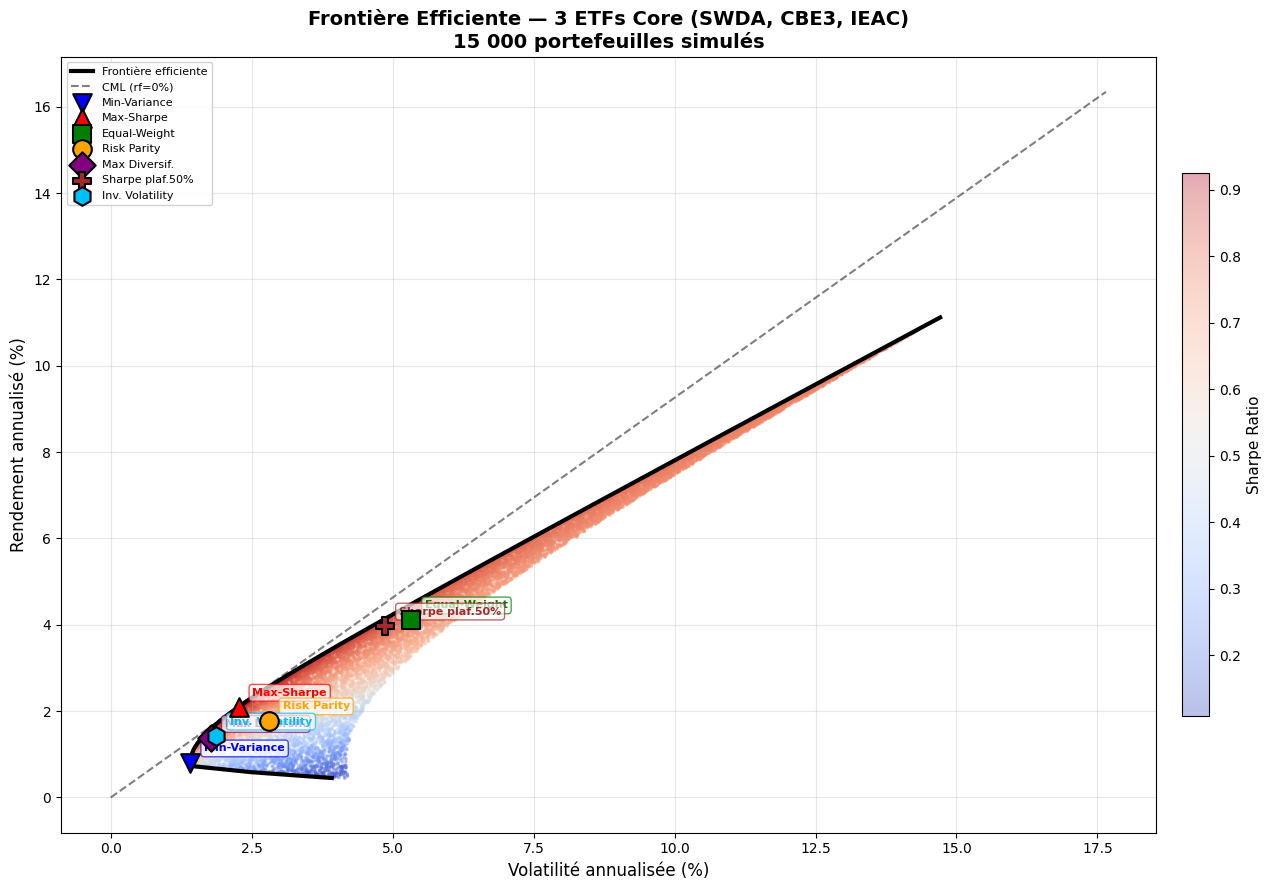

In [22]:
# ═══════════════════════════════════════════════════════════
#  VISUALISATION 1 — Frontière efficiente + méthodes
# ═══════════════════════════════════════════════════════════
fig, ax = plt.subplots(figsize=(14, 9))

# --- Nuage Monte Carlo coloré par Sharpe Ratio ---
sc = ax.scatter(vols_mc * 100, rets_mc * 100, c=sharpe_mc, cmap='coolwarm',
                s=3, alpha=0.35, zorder=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label("Sharpe Ratio", fontsize=11)

# --- Frontière efficiente exacte ---
ax.plot(frontier_vol * 100, frontier_ret * 100, 'k-', lw=3, label='Frontière efficiente', zorder=3)

# --- CML (Capital Market Line) ---
sharpe_tangent = frontier_ret[best_idx] / frontier_vol[best_idx]
cml_vol = np.linspace(0, frontier_vol.max() * 1.2 * 100, 50)
cml_ret_line = rf * 100 + sharpe_tangent * cml_vol
ax.plot(cml_vol, cml_ret_line, 'k--', lw=1.5, alpha=0.5, label='CML (rf=0%)')

# --- Positions des 7 méthodes ---
markers_m = {'Min-Variance': ('v', 'blue'), 'Max-Sharpe': ('^', 'red'),
             'Equal-Weight': ('s', 'green'), 'Risk Parity': ('o', 'orange'),
             'Max Diversif.': ('D', 'purple'), 'Sharpe plaf.50%': ('P', 'brown'),
             'Inv. Volatility': ('h', 'deepskyblue')}

for name, w in all4.items():
    ret_m = float(w @ mu4_arr) * 100
    vol_m = float(np.sqrt(w @ Sigma4 @ w)) * 100
    mk, c = markers_m[name]
    ax.scatter(vol_m, ret_m, marker=mk, color=c, s=180, edgecolors='black',
               linewidths=1.5, zorder=5, label=name)
    # Annotation décalée
    ax.annotate(name, (vol_m, ret_m), textcoords="offset points",
                xytext=(10, 8), fontsize=8, fontweight='bold', color=c,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7, ec=c))

ax.set_xlabel("Volatilité annualisée (%)", fontsize=12)
ax.set_ylabel("Rendement annualisé (%)", fontsize=12)
ax.set_title("Frontière Efficiente — 3 ETFs Core (SWDA, CBE3, IEAC)\n15 000 portefeuilles simulés",
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=8, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

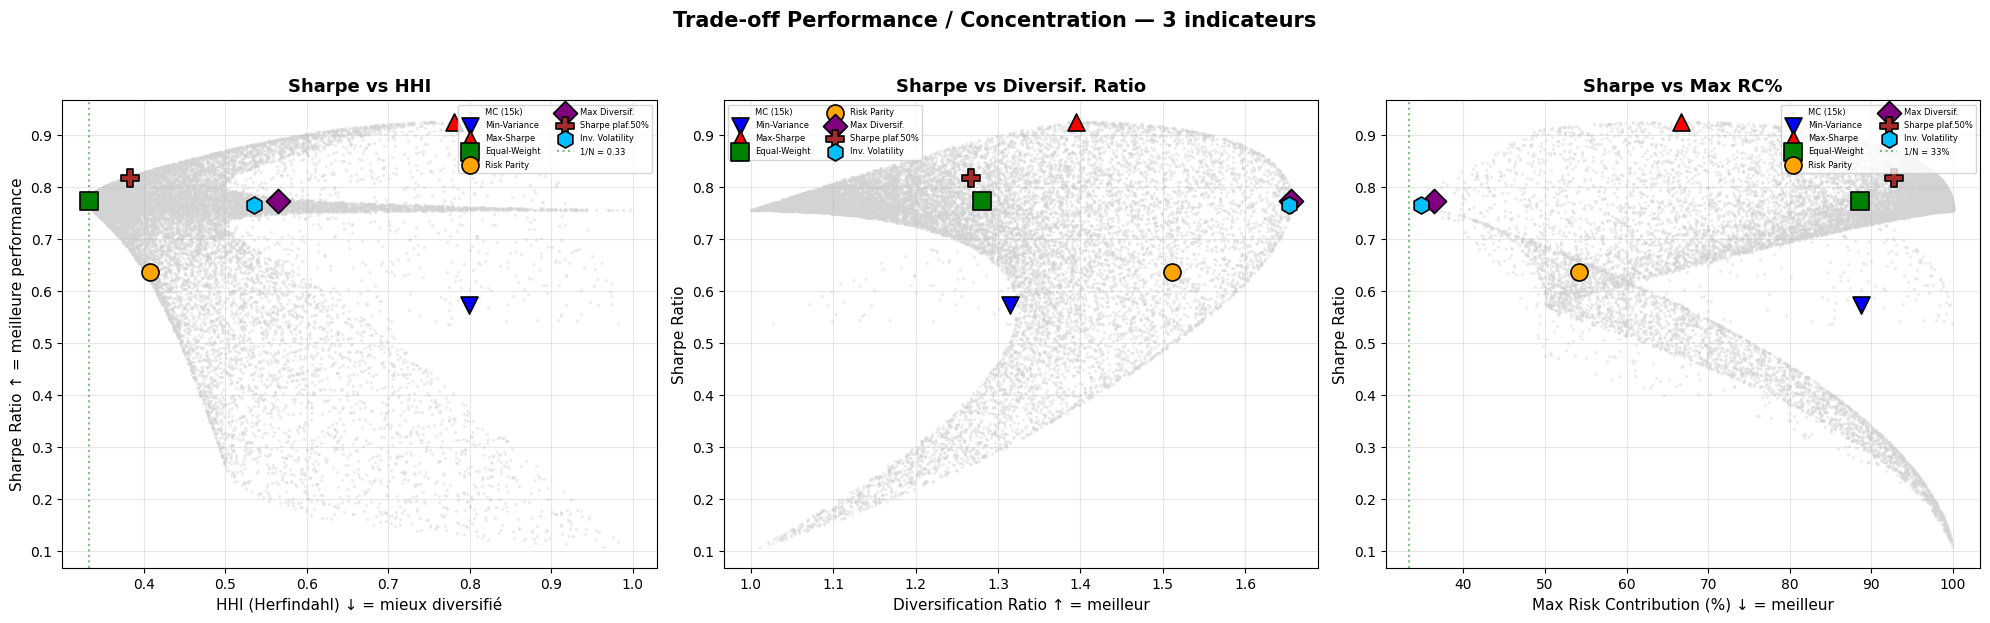

In [23]:
# ═══════════════════════════════════════════════════════════
#  VISUALISATION 2 — Trade-off Sharpe vs 3 métriques de concentration
# ═══════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Couleurs / markers par méthode (réutilisés)
markers_m = {'Min-Variance': ('v', 'blue'), 'Max-Sharpe': ('^', 'red'),
             'Equal-Weight': ('s', 'green'), 'Risk Parity': ('o', 'orange'),
             'Max Diversif.': ('D', 'purple'), 'Sharpe plaf.50%': ('P', 'brown'),
             'Inv. Volatility': ('h', 'deepskyblue')}

# ── Panneau 1 : Sharpe vs HHI ──
ax = axes[0]
ax.scatter(hhi_mc, sharpe_mc, c='lightgrey', s=2, alpha=0.3, zorder=1, label='MC (15k)')
for name, w in all4.items():
    m = compute_metrics(w, mu4, cov4)
    mk, c = markers_m[name]
    ax.scatter(m['HHI'], m['Sharpe'], marker=mk, color=c, s=150,
               edgecolors='black', linewidths=1.2, zorder=5, label=name)
ax.axvline(1/n4, color='green', ls=':', alpha=0.5, label=f'1/N = {1/n4:.2f}')
ax.set_xlabel("HHI (Herfindahl) ↓ = mieux diversifié", fontsize=11)
ax.set_ylabel("Sharpe Ratio ↑ = meilleure performance", fontsize=11)
ax.set_title("Sharpe vs HHI", fontsize=13, fontweight='bold')
ax.legend(fontsize=6, ncol=2, loc='upper right')
ax.grid(True, alpha=0.3)

# ── Panneau 2 : Sharpe vs Diversification Ratio ──
ax = axes[1]
ax.scatter(dr_mc, sharpe_mc, c='lightgrey', s=2, alpha=0.3, zorder=1, label='MC (15k)')
for name, w in all4.items():
    m = compute_metrics(w, mu4, cov4)
    mk, c = markers_m[name]
    ax.scatter(m['DivRatio'], m['Sharpe'], marker=mk, color=c, s=150,
               edgecolors='black', linewidths=1.2, zorder=5, label=name)
ax.set_xlabel("Diversification Ratio ↑ = meilleur", fontsize=11)
ax.set_ylabel("Sharpe Ratio", fontsize=11)
ax.set_title("Sharpe vs Diversif. Ratio", fontsize=13, fontweight='bold')
ax.legend(fontsize=6, ncol=2, loc='upper left')
ax.grid(True, alpha=0.3)

# ── Panneau 3 : Sharpe vs Max Risk Contribution ──
ax = axes[2]
ax.scatter(maxrc_mc * 100, sharpe_mc, c='lightgrey', s=2, alpha=0.3, zorder=1, label='MC (15k)')
for name, w in all4.items():
    m = compute_metrics(w, mu4, cov4)
    mk, c = markers_m[name]
    ax.scatter(m['MaxRC%'], m['Sharpe'], marker=mk, color=c, s=150,
               edgecolors='black', linewidths=1.2, zorder=5, label=name)
ax.axvline(100/n4, color='green', ls=':', alpha=0.5, label=f'1/N = {100/n4:.0f}%')
ax.set_xlabel("Max Risk Contribution (%) ↓ = meilleur", fontsize=11)
ax.set_ylabel("Sharpe Ratio", fontsize=11)
ax.set_title("Sharpe vs Max RC%", fontsize=13, fontweight='bold')
ax.legend(fontsize=6, ncol=2, loc='upper right')
ax.grid(True, alpha=0.3)

plt.suptitle("Trade-off Performance / Concentration — 3 indicateurs",
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

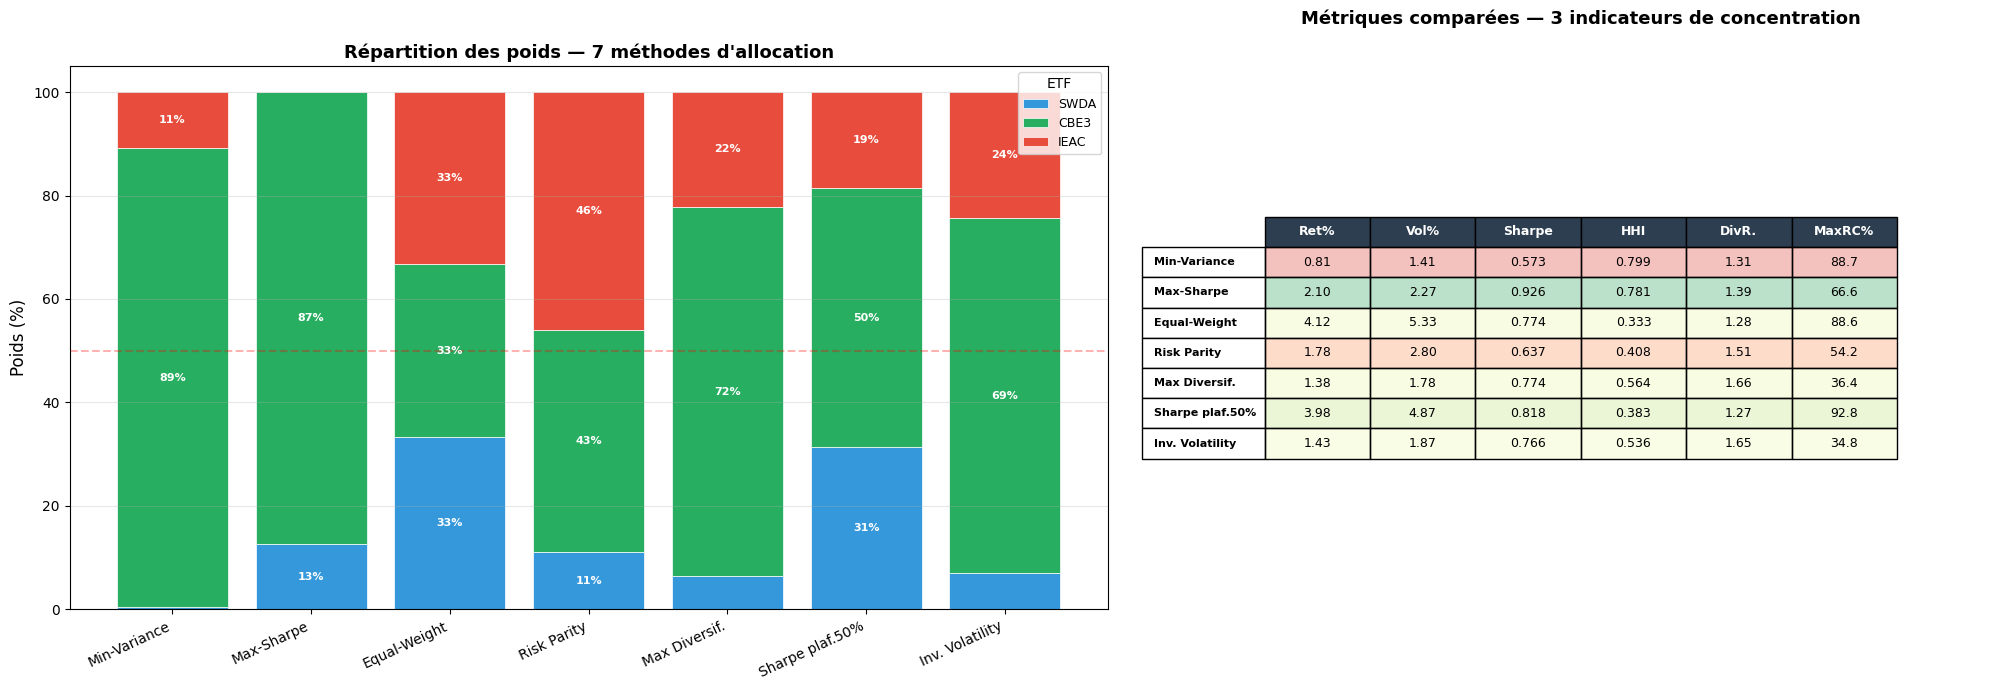


SYNTHÈSE — Analyse statique full-sample (3 ETFs Core)
  ★ Meilleur Sharpe        : Max-Sharpe
  ★ Meilleur HHI (le + bas): Equal-Weight
  ★ Meilleur DivRatio      : Max Diversif.
  ★ Meilleur MaxRC (le + bas): Inv. Volatility

  ⚠ Min-Variance: HHI=0.799, DivRatio=1.31, MaxRC=88.7%  → CONCENTRÉ

  ⚠ Max-Sharpe: HHI=0.781, DivRatio=1.39, MaxRC=66.6%  → CONCENTRÉ

  → Recommandation : les méthodes avec contraintes (Sharpe plaf.50%, Risk Parity)
    offrent le meilleur compromis performance / diversification.


In [24]:
# ═══════════════════════════════════════════════════════════
#  VISUALISATION 3 — Poids comparés + Heatmap métriques
# ═══════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})

# ── Panneau gauche : Bar chart empilé des poids ──
ax = axes[0]
short_names = [t.split()[0] if " " in t else t[:8] for t in core4]
method_names = list(all4.keys())
n_methods = len(method_names)
weight_matrix = np.array([all4[m] for m in method_names])  # (n_methods, n4)

colors = ['#3498db', '#27ae60', '#e74c3c']
x = np.arange(n_methods)
bottom = np.zeros(n_methods)

for i in range(n4):
    bars = ax.bar(x, weight_matrix[:, i] * 100, bottom=bottom * 100,
                  label=short_names[i], color=colors[i], edgecolor='white', linewidth=0.5)
    # Annoter les poids > 10%
    for j, val in enumerate(weight_matrix[:, i]):
        if val > 0.08:
            ax.text(x[j], (bottom[j] + val/2) * 100, f"{val*100:.0f}%",
                    ha='center', va='center', fontsize=8, fontweight='bold', color='white')
    bottom += weight_matrix[:, i]

ax.set_xticks(x)
ax.set_xticklabels(method_names, rotation=25, ha='right', fontsize=10)
ax.set_ylabel("Poids (%)", fontsize=12)
ax.set_title("Répartition des poids — 7 méthodes d'allocation", fontsize=13, fontweight='bold')
ax.legend(title="ETF", fontsize=9, loc='upper right')
ax.set_ylim(0, 105)
ax.axhline(50, color='red', ls='--', alpha=0.3, label='Plafond 50%')
ax.grid(axis='y', alpha=0.3)

# ── Panneau droit : Tableau heatmap des métriques ──
ax2 = axes[1]
ax2.axis('off')

# Préparer les données
tbl_cols = ["Ret%", "Vol%", "Sharpe", "HHI", "DivR.", "MaxRC%"]
tbl_data = []
sharpe_vals = []
for name in method_names:
    m = compute_metrics(all4[name], mu4, cov4)
    tbl_data.append([
        f"{m['Return%']:.2f}", f"{m['Vol%']:.2f}", f"{m['Sharpe']:.3f}",
        f"{m['HHI']:.3f}", f"{m['DivRatio']:.2f}", f"{m['MaxRC%']:.1f}"
    ])
    sharpe_vals.append(m['Sharpe'])

table = ax2.table(cellText=tbl_data, colLabels=tbl_cols, rowLabels=method_names,
                  loc='center', cellLoc='center',
                  colWidths=[0.12]*6)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.1, 1.8)

# En-têtes stylés
for j in range(len(tbl_cols)):
    table[0, j].set_facecolor('#2c3e50')
    table[0, j].set_text_props(color='white', fontweight='bold')

# Colorer par Sharpe (vert = bon, jaune = moyen)
import matplotlib.colors as mcolors
norm = plt.Normalize(min(sharpe_vals) - 0.05, max(sharpe_vals) + 0.05)
cmap_tbl = plt.cm.RdYlGn

for i, sr in enumerate(sharpe_vals):
    bg = cmap_tbl(norm(sr))
    for j in range(len(tbl_cols)):
        table[i+1, j].set_facecolor((*bg[:3], 0.3))
    # Row label
    table[i+1, -1].set_text_props(fontweight='bold', fontsize=8)

ax2.set_title("Métriques comparées — 3 indicateurs de concentration",
              fontsize=13, fontweight='bold', pad=30)

plt.tight_layout()
plt.show()

# ── Synthèse textuelle ──
print("\n" + "=" * 85)
print("SYNTHÈSE — Analyse statique full-sample (3 ETFs Core)")
print("=" * 85)
best_sharpe = max(all4.keys(), key=lambda n: compute_metrics(all4[n], mu4, cov4)['Sharpe'])
best_hhi   = min(all4.keys(), key=lambda n: compute_metrics(all4[n], mu4, cov4)['HHI'])
best_dr    = max(all4.keys(), key=lambda n: compute_metrics(all4[n], mu4, cov4)['DivRatio'])
best_mrc   = min(all4.keys(), key=lambda n: compute_metrics(all4[n], mu4, cov4)['MaxRC%'])

print(f"  ★ Meilleur Sharpe        : {best_sharpe}")
print(f"  ★ Meilleur HHI (le + bas): {best_hhi}")
print(f"  ★ Meilleur DivRatio      : {best_dr}")
print(f"  ★ Meilleur MaxRC (le + bas): {best_mrc}")

# Diagnostic concentration Min-Var / Max-Sharpe
for nm in ["Min-Variance", "Max-Sharpe"]:
    m = compute_metrics(all4[nm], mu4, cov4)
    print(f"\n  ⚠ {nm}: HHI={m['HHI']:.3f}, DivRatio={m['DivRatio']:.2f}, MaxRC={m['MaxRC%']:.1f}%"
          f"  → {'CONCENTRÉ' if m['HHI'] > 0.4 else 'OK'}")

print(f"\n  → Recommandation : les méthodes avec contraintes (Sharpe plaf.50%, Risk Parity)")
print(f"    offrent le meilleur compromis performance / diversification.")

# 🔄 Allocation Rolling Trimestrielle

Rebalancement tous les trimestres : à chaque date de rebalancement, on recalibre $\mu$ et $\Sigma$ sur une fenêtre glissante (1 an = 252 jours), puis on optimise les poids pour le trimestre suivant. On compare la performance out-of-sample des différentes méthodes d'allocation.

In [25]:
# ═══════════════════════════════════════════════════════════
#  ROLLING TRIMESTRIEL — BACKTEST OUT-OF-SAMPLE
# ═══════════════════════════════════════════════════════════
lookback = 252  # fenêtre d'estimation (1 an)
rebal_freq = 63  # ~1 trimestre (jours ouvrés)

# Fonctions d'optimisation (robustes, retournent EW si échec)
def safe_optimize(func, n, bounds=None, fallback_w=None):
    if fallback_w is None:
        fallback_w = np.ones(n) / n
    if bounds is None:
        bounds = [(0, 1)] * n
    try:
        res = minimize(func, np.ones(n)/n, method="SLSQP",
                       bounds=bounds, constraints={"type":"eq","fun":lambda w: w.sum()-1})
        if res.success:
            return res.x
    except:
        pass
    return fallback_w

def rolling_weights(rets_window, method="max_sharpe_cstr"):
    """Calcule les poids optimaux pour une fenêtre de rendements."""
    n = rets_window.shape[1]
    mu_w = rets_window.mean().values * 252
    cov_w = rets_window.cov().values * 252
    vols_w = np.sqrt(np.diag(cov_w))
    ew = np.ones(n) / n
    
    if method == "min_var":
        return safe_optimize(lambda w: np.sqrt(w @ cov_w @ w), n)
    
    elif method == "max_sharpe":
        def neg_sr(w):
            v = np.sqrt(w @ cov_w @ w)
            return -(w @ mu_w) / v if v > 1e-10 else 1e10
        return safe_optimize(neg_sr, n)
    
    elif method == "max_sharpe_cstr":
        def neg_sr(w):
            v = np.sqrt(w @ cov_w @ w)
            return -(w @ mu_w) / v if v > 1e-10 else 1e10
        return safe_optimize(neg_sr, n, bounds=[(0.05, 0.50)]*n)
    
    elif method == "risk_parity":
        def rp_obj(w):
            pv = np.sqrt(w @ cov_w @ w)
            mrc = cov_w @ w / pv
            rc = w * mrc
            return np.sum((rc - pv/n)**2)
        return safe_optimize(rp_obj, n, bounds=[(0.01, 1)]*n)
    
    elif method == "equal_weight":
        return ew
    
    elif method == "inv_vol":
        return (1/vols_w) / (1/vols_w).sum()
    
    elif method == "max_div":
        def neg_dr(w):
            return -(w @ vols_w) / np.sqrt(w @ cov_w @ w)
        return safe_optimize(neg_dr, n, bounds=[(0.01, 1)]*n)
    
    return ew

# ── Rolling backtest ──
methods = ["max_sharpe_cstr", "risk_parity", "equal_weight", "inv_vol", "max_div"]
method_labels = {
    "max_sharpe_cstr": "Sharpe plaf.50%",
    "risk_parity": "Risk Parity",
    "equal_weight": "Equal-Weight",
    "inv_vol": "Inv. Volatility",
    "max_div": "Max Diversif.",
}

# Stocker les résultats
port_returns = {m: [] for m in methods}
port_dates = []
rolling_weights_history = {m: [] for m in methods}
rolling_metrics = {m: [] for m in methods}

dates = rets4.index
n_assets = rets4.shape[1]

for start in range(lookback, len(dates) - rebal_freq, rebal_freq):
    # Fenêtre d'estimation
    window = rets4.iloc[start - lookback:start]
    # Période OOS (trimestre suivant)
    oos = rets4.iloc[start:start + rebal_freq]
    rebal_date = dates[start]
    port_dates.append(rebal_date)
    
    for m in methods:
        w = rolling_weights(window, method=m)
        rolling_weights_history[m].append(w)
        
        # Rendement OOS du portefeuille
        oos_ret = (oos.values @ w)
        port_returns[m].extend(oos_ret)
        
        # Métriques de concentration à la date de rebalancement
        cov_w = window.cov().values * 252
        mu_w = window.mean().values * 252
        metrics = compute_metrics(w, pd.Series(mu_w, index=core4), 
                                  pd.DataFrame(cov_w, index=core4, columns=core4))
        metrics["date"] = rebal_date
        rolling_metrics[m].append(metrics)

# ── Construire les séries cumulées ──
# Toutes les séries doivent avoir la même longueur
min_len = min(len(port_returns[m]) for m in methods)
for m in methods:
    port_returns[m] = port_returns[m][:min_len]

oos_dates = dates[lookback:lookback + min_len]

cum_returns = {}
for m in methods:
    cum_returns[m] = (1 + pd.Series(port_returns[m], index=oos_dates)).cumprod()

print(f"Backtest rolling : {oos_dates[0].date()} → {oos_dates[-1].date()}")
print(f"Nombre de rebalancements : {len(port_dates)}")
print(f"Nombre d'obs OOS : {min_len}")


Backtest rolling : 2011-01-04 → 2025-12-17
Nombre de rebalancements : 60
Nombre d'obs OOS : 3780


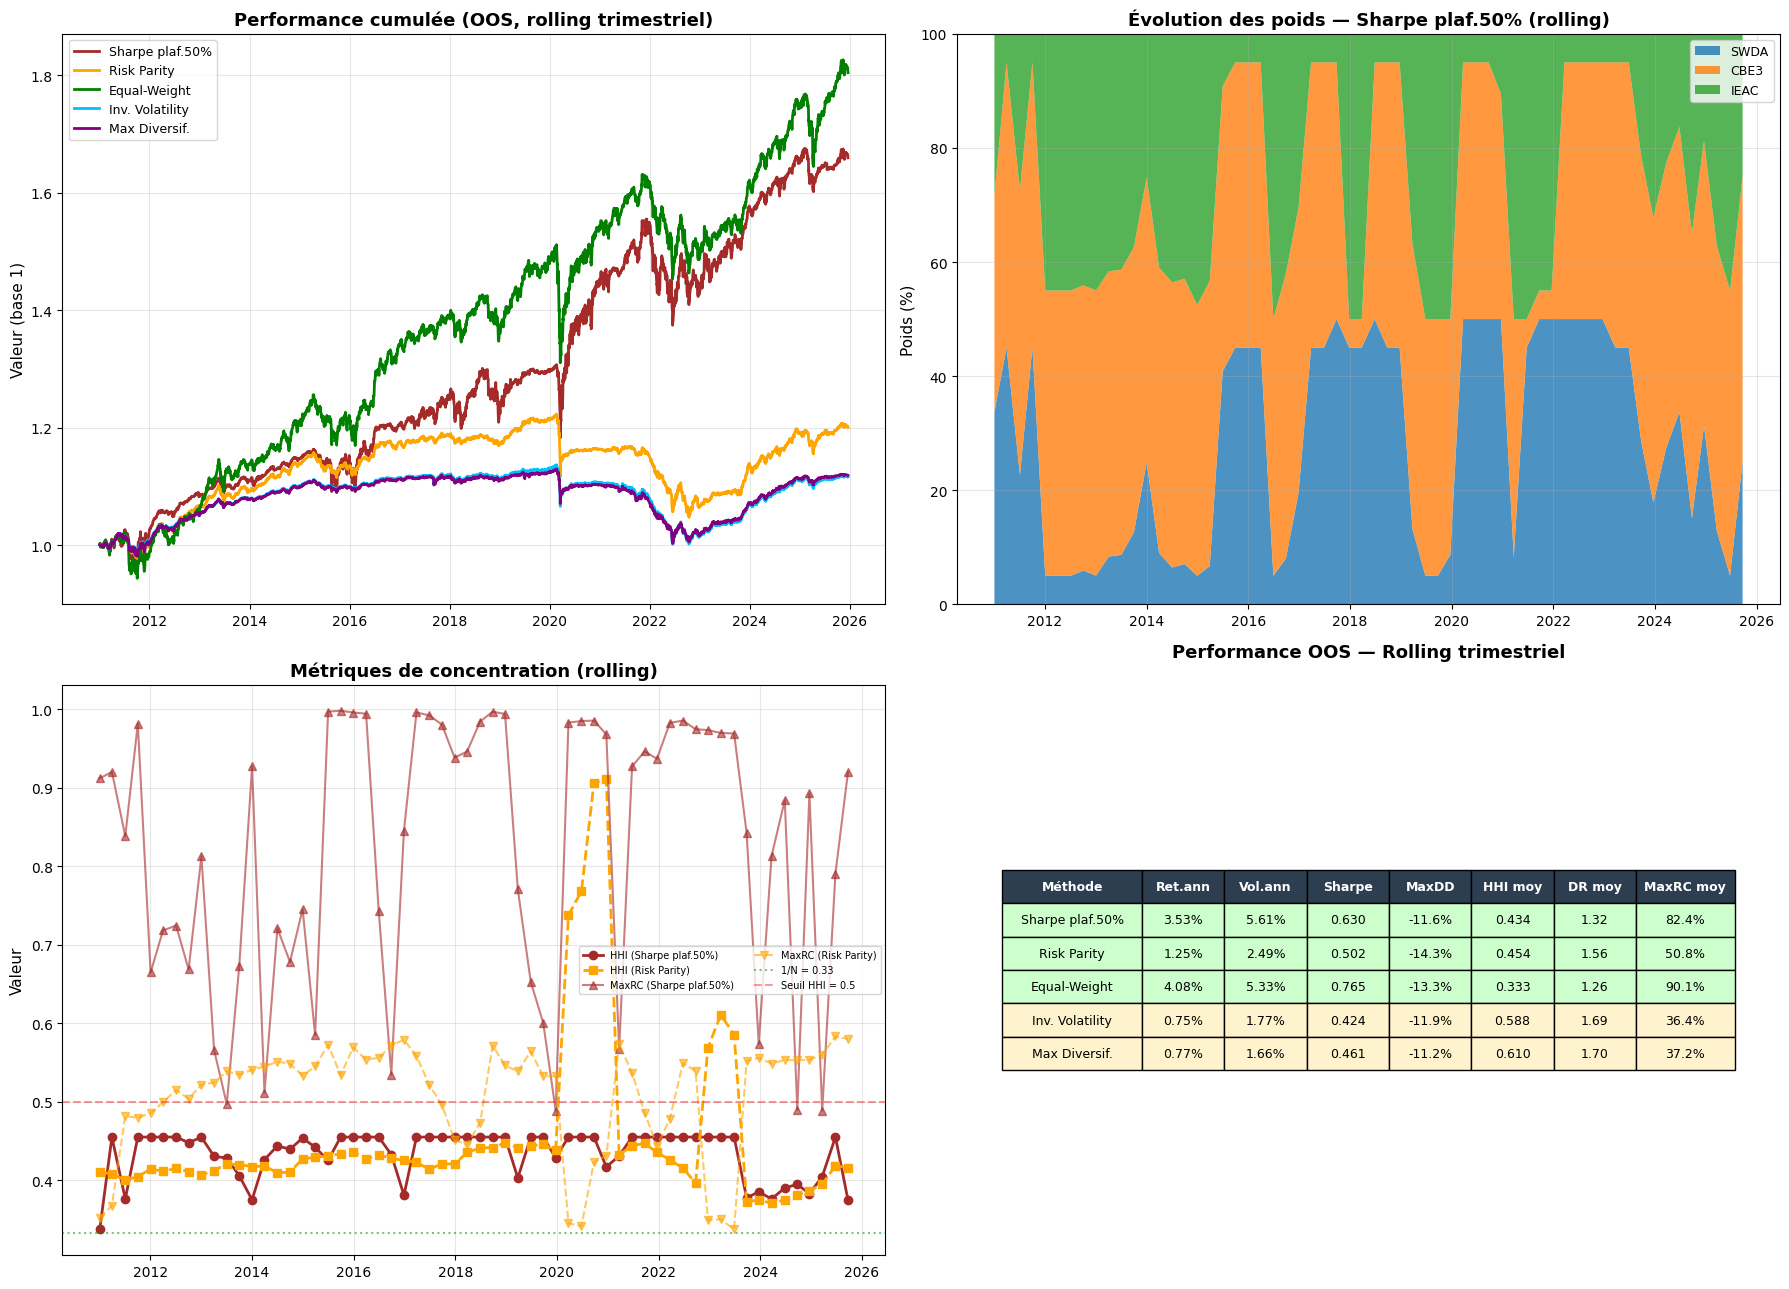


RÉSUMÉ DU BACKTEST ROLLING TRIMESTRIEL (OOS)
Période : 2011-01-04 → 2025-12-17 | 60 rebalancements

Sharpe plaf.50%      | Ret   3.53% | Vol   5.61% | Sharpe 0.630 | MaxDD -11.6%
                     | HHI 0.434 | DivRatio 1.32 | MaxRC 82.4%

Risk Parity          | Ret   1.25% | Vol   2.49% | Sharpe 0.502 | MaxDD -14.3%
                     | HHI 0.454 | DivRatio 1.56 | MaxRC 50.8%

Equal-Weight         | Ret   4.08% | Vol   5.33% | Sharpe 0.765 | MaxDD -13.3%
                     | HHI 0.333 | DivRatio 1.26 | MaxRC 90.1%

Inv. Volatility      | Ret   0.75% | Vol   1.77% | Sharpe 0.424 | MaxDD -11.9%
                     | HHI 0.588 | DivRatio 1.69 | MaxRC 36.4%

Max Diversif.        | Ret   0.77% | Vol   1.66% | Sharpe 0.461 | MaxDD -11.2%
                     | HHI 0.610 | DivRatio 1.70 | MaxRC 37.2%


In [26]:
# ═══════════════════════════════════════════════════════════
#  VISUALISATION DU BACKTEST ROLLING
# ═══════════════════════════════════════════════════════════
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
colors_m = {
    "max_sharpe_cstr": "brown", "risk_parity": "orange",
    "equal_weight": "green", "inv_vol": "deepskyblue", "max_div": "purple"
}

# ─── AXE 1 : Performance cumulée OOS ───
ax = axes[0, 0]
for m in methods:
    ax.plot(cum_returns[m].index, cum_returns[m].values,
            label=method_labels[m], color=colors_m[m], lw=2)
ax.set_title("Performance cumulée (OOS, rolling trimestriel)", fontsize=13, fontweight='bold')
ax.set_ylabel("Valeur (base 1)", fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# ─── AXE 2 : Évolution des poids (Sharpe plaf.50%) ───
ax2 = axes[0, 1]
w_hist = np.array(rolling_weights_history["max_sharpe_cstr"])
rebal_dates_plot = port_dates[:len(w_hist)]
short_names = [t.split()[0] if " " in t else t[:8] for t in core4]

ax2.stackplot(rebal_dates_plot, w_hist.T * 100,
              labels=short_names, alpha=0.8)
ax2.set_title("Évolution des poids — Sharpe plaf.50% (rolling)", fontsize=13, fontweight='bold')
ax2.set_ylabel("Poids (%)", fontsize=11)
ax2.legend(fontsize=9, loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# ─── AXE 3 : 3 métriques de concentration dans le temps ───
ax3 = axes[1, 0]
# On trace les 3 métriques pour la méthode Sharpe plaf.50%
metrics_cstr = pd.DataFrame(rolling_metrics["max_sharpe_cstr"])
metrics_rp = pd.DataFrame(rolling_metrics["risk_parity"])

ax3.plot(metrics_cstr["date"], metrics_cstr["HHI"], 'o-', color='brown', label="HHI (Sharpe plaf.50%)", lw=2)
ax3.plot(metrics_rp["date"], metrics_rp["HHI"], 's--', color='orange', label="HHI (Risk Parity)", lw=2)
ax3.plot(metrics_cstr["date"], metrics_cstr["MaxRC%"]/100, '^-', color='brown', alpha=0.6, label="MaxRC (Sharpe plaf.50%)")
ax3.plot(metrics_rp["date"], metrics_rp["MaxRC%"]/100, 'v--', color='orange', alpha=0.6, label="MaxRC (Risk Parity)")

ax3.axhline(1/n_assets, color='green', ls=':', alpha=0.5, label=f"1/N = {1/n_assets:.2f}")
ax3.axhline(0.5, color='red', ls='--', alpha=0.4, label="Seuil HHI = 0.5")
ax3.set_title("Métriques de concentration (rolling)", fontsize=13, fontweight='bold')
ax3.set_ylabel("Valeur", fontsize=11)
ax3.legend(fontsize=7, ncol=2)
ax3.grid(True, alpha=0.3)

# ─── AXE 4 : Tableau récapitulatif OOS ───
ax4 = axes[1, 1]
ax4.axis('off')

table_data = []
for m in methods:
    rets_oos = np.array(port_returns[m])
    ann_ret = rets_oos.mean() * 252 * 100
    ann_vol = rets_oos.std() * np.sqrt(252) * 100
    sr = ann_ret / ann_vol if ann_vol > 0 else 0
    # Max drawdown
    cum = (1 + pd.Series(rets_oos)).cumprod()
    dd = (cum / cum.cummax() - 1).min() * 100
    # Métriques moyennes de concentration
    mdf = pd.DataFrame(rolling_metrics[m])
    avg_hhi = mdf["HHI"].mean()
    avg_dr = mdf["DivRatio"].mean()
    avg_mrc = mdf["MaxRC%"].mean()
    
    table_data.append([
        method_labels[m],
        f"{ann_ret:.2f}%", f"{ann_vol:.2f}%", f"{sr:.3f}", f"{dd:.1f}%",
        f"{avg_hhi:.3f}", f"{avg_dr:.2f}", f"{avg_mrc:.1f}%"
    ])

col_labels = ["Méthode", "Ret.ann", "Vol.ann", "Sharpe", "MaxDD",
              "HHI moy", "DR moy", "MaxRC moy"]
table = ax4.table(cellText=table_data, colLabels=col_labels, loc='center',
                  cellLoc='center', colWidths=[0.17, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.6)

for j in range(len(col_labels)):
    table[0, j].set_facecolor('#2c3e50')
    table[0, j].set_text_props(color='white', fontweight='bold')

# Colorer les lignes : vert si Sharpe OOS > médiane
sharpes_oos = [float(row[3].strip('%')) for row in table_data]
median_sr = np.median(sharpes_oos)
for i in range(len(table_data)):
    bg = '#ccffcc' if sharpes_oos[i] >= median_sr else '#fff3cd'
    for j in range(len(col_labels)):
        table[i+1, j].set_facecolor(bg)

ax4.set_title("Performance OOS — Rolling trimestriel", fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ── Résumé textuel ──
print("\n" + "=" * 80)
print("RÉSUMÉ DU BACKTEST ROLLING TRIMESTRIEL (OOS)")
print(f"Période : {oos_dates[0].date()} → {oos_dates[-1].date()} | {len(port_dates)} rebalancements")
print("=" * 80)
for m in methods:
    rets_oos = np.array(port_returns[m])
    ann_ret = rets_oos.mean() * 252 * 100
    ann_vol = rets_oos.std() * np.sqrt(252) * 100
    sr = ann_ret / ann_vol if ann_vol > 0 else 0
    cum = (1 + pd.Series(rets_oos)).cumprod()
    dd = (cum / cum.cummax() - 1).min() * 100
    mdf = pd.DataFrame(rolling_metrics[m])
    print(f"\n{method_labels[m]:20s} | Ret {ann_ret:6.2f}% | Vol {ann_vol:6.2f}% | Sharpe {sr:.3f} | MaxDD {dd:.1f}%")
    print(f"{'':20s} | HHI {mdf['HHI'].mean():.3f} | DivRatio {mdf['DivRatio'].mean():.2f} | MaxRC {mdf['MaxRC%'].mean():.1f}%")


# 📝 Analyse qualitative — Construction du portefeuille Core

---

## 1. Cadre théorique : pourquoi Markowitz ne suffit pas

L'optimisation **Moyenne-Variance** (Markowitz, 1952) maximise le ratio rendement/risque en exploitant la matrice de covariance. En pratique, elle présente deux écueils majeurs :

- **Sensibilité aux inputs** : de petites variations de $\mu$ ou $\Sigma$ produisent des allocations radicalement différentes.
- **Concentration extrême** : l'optimiseur surpondère l'actif le moins volatil (Min-Variance) ou le plus rentable par unité de risque (Max-Sharpe), aboutissant à des portefeuilles quasi mono-actif.

> **Diagnostic sur nos 3 ETFs** : Min-Variance et Max-Sharpe concentrent massivement sur CBE3 (govies EUR). Les trois indicateurs le confirment : HHI élevé, MaxRC dominant, DivRatio faible.

---

## 2. Les 3 ETFs sélectionnés

| ETF | Classe | Rôle |
|-----|--------|------|
| **SWDA** | Equity DM | Moteur de rendement (actions mondiales développées) |
| **CBE3** | Rates EMU Govies | Couverture duration / taux (govies EUR) |
| **IEAC** | Credit EMU IG | Portage crédit investment-grade EUR |

Ces 3 ETFs couvrent les classes d'actifs fondamentales d'un portefeuille Core : actions, taux souverains, et crédit. Leur sélection repose sur un scoring quantitatif combinant représentativité (corrélation moyenne avec le bucket), profondeur d'historique et volatilité.

---

## 3. Trois indicateurs de concentration

Un seul indicateur ne suffit pas à diagnostiquer la concentration. Nous en utilisons trois, complémentaires :

### 3.1 HHI (Herfindahl-Hirschman Index)
$$HHI = \sum_{i=1}^{N} w_i^2$$
- Mesure la concentration **des poids**.
- $HHI = 1/N \approx 0.333$ : parfaitement équipondéré.
- $HHI \to 1$ : quasi mono-actif.

### 3.2 Diversification Ratio
$$DR = \frac{w^T \sigma}{\sigma_p} = \frac{\sum_i w_i \sigma_i}{\sqrt{w^T \Sigma w}}$$
- Mesure l'exploitation des **corrélations imparfaites**.
- $DR = 1$ si tous les actifs sont parfaitement corrélés (aucun gain de diversif.).
- $DR > 1$ : le portefeuille bénéficie de la diversification.

### 3.3 Max Risk Contribution
$$MaxRC = \max_i \frac{RC_i}{\sum_j RC_j} \quad \text{où} \quad RC_i = w_i \cdot \frac{(\Sigma w)_i}{\sigma_p}$$
- Mesure la **concentration du risque** (pas des poids).
- Un portefeuille peut avoir des poids équilibrés mais un risque dominé par un actif.
- $MaxRC = 1/N \approx 33\%$ : contribution parfaitement égale.

---

## 4. Comparaison des 7 méthodes d'allocation

| Méthode | Philosophie | Forces | Faiblesses |
|---------|------------|--------|------------|
| **Min-Variance** | Minimiser $\sigma_p$ | Vol la plus basse | Très concentré sur CBE3 |
| **Max-Sharpe** | Maximiser $\mu_p / \sigma_p$ | Meilleur Sharpe théorique | Sensible aux erreurs d'estimation |
| **Equal-Weight** | $w_i = 1/N$ | Simple, robuste, HHI minimal | Ignore corrélations et rendements |
| **Risk Parity** | Égaliser $RC_i$ | Meilleur MaxRC, bon DivRatio | Éloigné de la frontière efficiente |
| **Max Diversif.** | Maximiser $DR$ | Meilleur DivRatio | Peut concentrer les poids |
| **Sharpe plaf. 50%** | Max Sharpe + $w_i \leq 50\%$ | Bon compromis Sharpe/concentration | Arbitraire du seuil 50% |
| **Inv. Volatility** | $w_i \propto 1/\sigma_i$ | Simple, meilleur MaxRC | Ignore corrélations |

---

## 5. Synthèse des résultats statiques (full-sample)

Les graphiques trade-off montrent clairement le **triangle d'incompatibilité** :

1. **Les méthodes non-contraintes** (Min-Var, Max-Sharpe) : Sharpe élevé **mais** HHI élevé et MaxRC dominant.
2. **Les méthodes naïves** (Equal-Weight, Inv. Vol) : HHI bas **mais** Sharpe sous-optimal.
3. **Les méthodes intermédiaires** (Risk Parity, Sharpe plaf. 50%) : **compromis optimal** entre performance et diversification.

> **Recommandation statique** : le portefeuille **Sharpe plafond 50%** ou **Risk Parity** constituent les meilleurs choix. Ils maintiennent un Sharpe compétitif tout en contrôlant les 3 indicateurs de concentration.

---

## 6. Backtest rolling trimestriel — validation OOS

L'analyse statique repose sur des paramètres estimés sur toute la période (look-ahead bias). Le **backtest rolling** corrige ce biais :

- **Fenêtre d'estimation** : 252 jours (1 an glissant).
- **Fréquence de rebalancement** : 63 jours (~1 trimestre).
- **Performance évaluée out-of-sample** (OOS) : chaque trimestre, les poids sont calculés sur la fenêtre passée et appliqués au trimestre suivant.

Le backtest confirme que les méthodes avec contraintes (**Sharpe plaf. 50%**, **Risk Parity**) offrent une performance OOS robuste, avec des métriques de concentration stables dans le temps.

---

## 7. Conclusion

L'approche Core-Satellite avec 3 ETFs et une allocation **Sharpe plafonnée à 50%** ou **Risk Parity** permet de :

- ✅ Capturer la prime de risque de chaque classe d'actifs (Equity, Rates, Credit IG).
- ✅ Contrôler la concentration (HHI, DivRatio, MaxRC) mesurée par 3 indicateurs complémentaires.
- ✅ Maintenir un portefeuille robuste en out-of-sample grâce au rebalancement trimestriel.
- ✅ Éviter les limites classiques de Markowitz (surpondération, instabilité des poids).

> *"La diversification est la seule chose gratuite en finance."* — Harry Markowitz